# py_lqr-riccati.ipynb

## Lecture 8 of CMU16-745 (2025)
Created: Feb 26, 25



In [12]:
import numpy as np 
from numpy.linalg import norm, solve
import matplotlib.pyplot as plt 
import control as ctl

In [2]:
# discrete dynamics
h = 0.1  # time step
A = np.array([[1,h],[0,1]])
B = np.array([0.5*h*h, h]).reshape(2,1)

In [3]:
n = 2     # number of state
m = 1     # number of controls
Tfinal = 10.0 # final time #try larger values
N = int(Tfinal/h)+1    # number of time steps
thist = np.arange(0,h*(N-1),h)

In [4]:
# Initial condiations
x0 = np.array([[1.0],[0]])

In [5]:
# Cost weights
Q = 1.0*np.eye(2)
R = np.array([[0.1]])
Qn = 1.0*np.eye(2)

In [6]:
def J(xhist, uhist):
    xend = xhist[:,-1]
    cost = 0.5*xend.T@Qn@xend
    for k in range(N-1):
        xk = xhist[:,k]
        uk = uhist[k]
        cost = cost + 0.5*xk.T@Q@xk + 0.5*uk*R*uk
    return cost

In [43]:
# plotx() and plotu() will be used in later examples
def plotx(t,x):
    plt.figure()
    plt.plot(t,x[0,0:N-1],"b-",thist,xhist[1,0:N-1],'orange')
    plt.xlabel("time (sec)")
    plt.ylabel("x(k)")
    plt.legend(["Position","Velocity"])
    plt.grid(True)
    plt.show()   

def plotu(t,u):
    plt.figure()
    plt.plot(t,u,"m-")
    plt.xlabel("time (sec)")
    plt.ylabel("u(k)")
    plt.grid(True)
    plt.show()      

In [28]:
P = np.zeros((n,n,N))
K = np.zeros((m,n,N-1))
P[:,:,N-1] = Qn

# Backward Riccati recursion
for k in range(N-1,0,-1):
    K[:,:,k-1] = solve(R + B.T@P[:,:,k]@B,B.T@P[:,:,k]@A)
    P[:,:,k-1] = Q + A.T@P[:,:,k]@(A-B@K[:,:,k-1])

# Forward rollout starting at x0 
xhist = np.zeros((n,N))
xhist[:,[0]] = x0
uhist = np.zeros((m,N-1))
for k in range(N-1):
    uhist[:,[k]] = -K[:,:,k]@xhist[:,[k]]
    xhist[:,[k+1]] = A@xhist[:,[k]] + B*uhist[:,[k]]

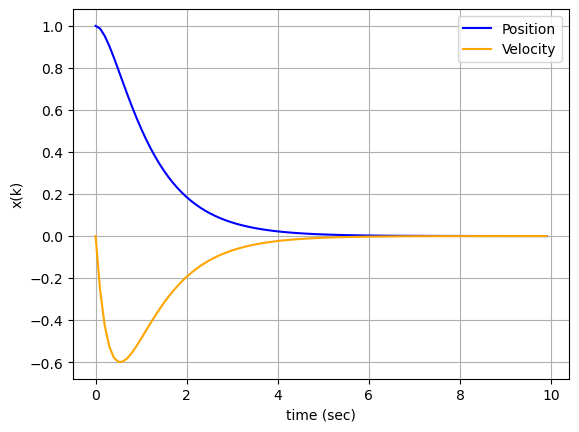

In [29]:
plotx(thist,xhist)

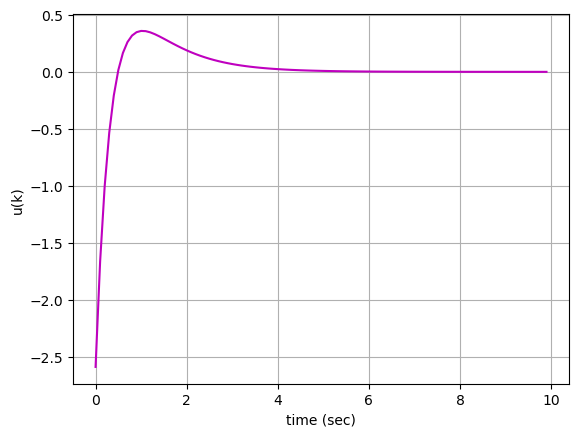

In [46]:
uhist= uhist.flatten()
plotu(thist,uhist)

In [48]:
J(xhist,uhist).item()

6.658612208961312

In [74]:
# Forward rollout with random noise and arbitrary initial condition
xhist = np.zeros((n,N))
xhist[:,[0]] = x0 + 10*np.random.rand(2,1)
uhist = np.zeros((m,N-1))
for k in range(N-1):
    uhist[:,[k]] = -K[:,:,k]@xhist[:,[k]]
    xhist[:,[k+1]] = A@xhist[:,[k]] + B*uhist[:,[k]] + 0.05*np.random.rand(2,1)

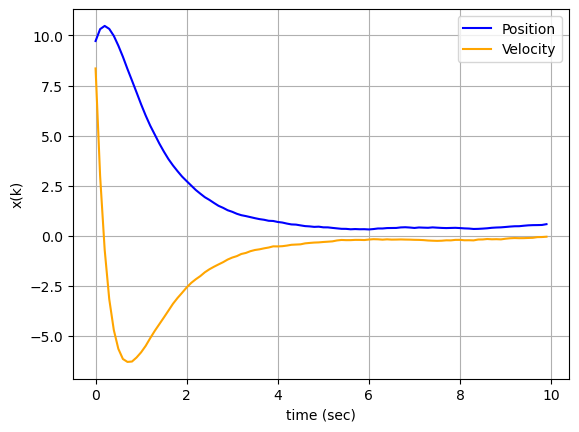

In [75]:
plotx(thist,xhist)

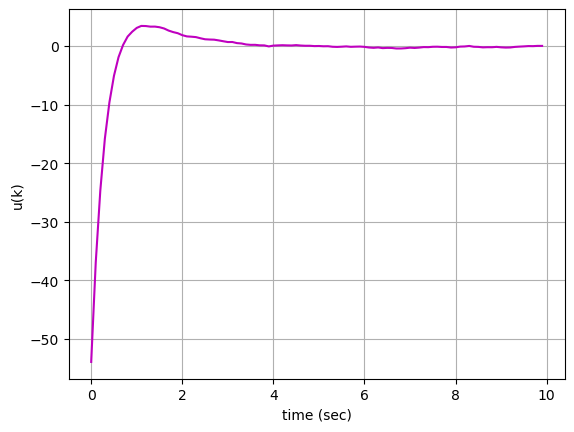

In [76]:
uhist= uhist.flatten()
plotu(thist,uhist)

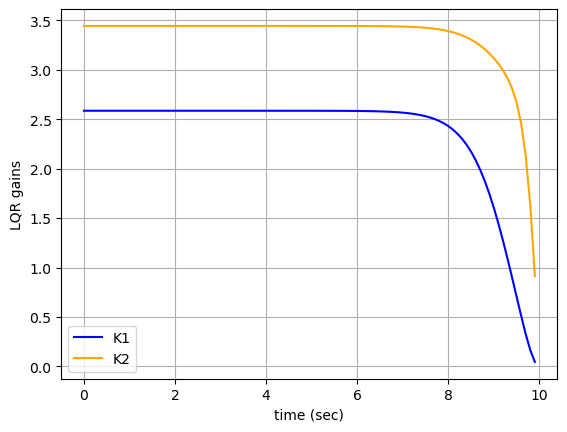

In [80]:
plt.figure()
plt.plot(thist,K[0,0,:],'b')
plt.plot(thist,K[0,1,:],'orange')
plt.legend(['K1','K2'])
plt.xlabel('time (sec)')
plt.ylabel('LQR gains')
plt.grid(True)
plt.show()


In [89]:
# Compute infinite-horizon K matrix using Control Systems library
Kinf = ctl.dlqr(A,B,Q,R)
Kinf = Kinf[0]
# Compare to ours
norm(K[:,:,0] - Kinf)

7.107529720652474e-09

In [90]:
# Forward rollout with constant K
xhist = np.zeros((n,N))
xhist[:,[0]] = x0 
uhist = np.zeros((m,N-1))
for k in range(N-1):
    uhist[:,[k]] = -Kinf@xhist[:,[k]]
    xhist[:,[k+1]] = A@xhist[:,[k]] + B*uhist[:,[k]] 

In [84]:
K[:,:,0]

array([[2.58570089, 3.44343592]])

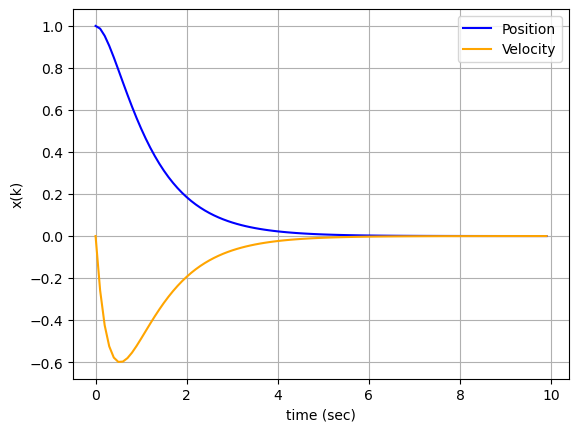

In [91]:
plotx(thist,xhist)

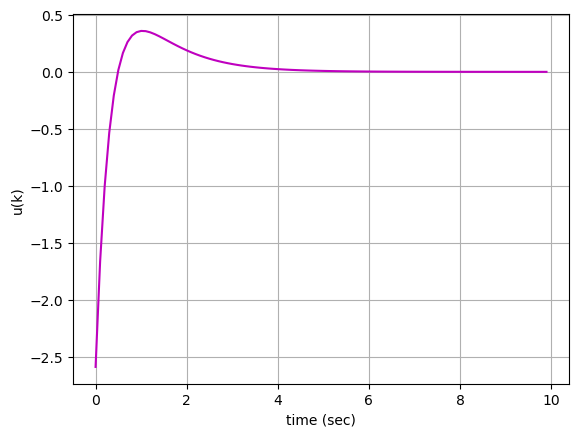

In [92]:
uhist= uhist.flatten()
plotu(thist,uhist)